# IDENTIFY TARGET PREFERENCE

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import pickle
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from paths import Paths
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn import metrics
import scipy as sp
from scipy.special import softmax
from scipy.optimize import minimize
from bandits_helper_functions import*
from exponential_model import Exponential_model, Optimize_exponent
from exponential_model import*
import pickle as pkl
import datetime
from openpyxl import load_workbook

## Define paths, import data

In [17]:
paths = Paths()
fig_save_path = paths.fig_save_path + '/target_preference_identification/'
data = pd.read_excel(paths.data + 'behavioural_data.xlsx', index_col=[0], converters={'session': str})

In [18]:
data["date"] = pd.to_datetime(data["session"], format = "%d%m%y")
data["date"] =  data['date'].dt.date

## Data formatting
- Drop the trials where the monkey didn't make any choice
- Keep only a smaller subset with the relevant columns

In [19]:
data = data.loc[~data['feedback'].isnull()]
data.loc[data['best_target'] == data['target'], 'best_chosen_match'] = 1
data.loc[data['best_target'] != data['target'], 'best_chosen_match'] = 0
data_subset = data[['monkey', 'session', 'date', 'trial_id', 'block_id', 'best_target', 'target', 'feedback', 'best_chosen_match']]

## Split the data according to the subject

In [14]:
po_data = data_subset.loc[data_subset['monkey'] == 'po']
po_data = get_shift_stay_variables(po_data)

ka_data = data_subset.loc[data_subset['monkey'] == 'ka']
ka_data = get_shift_stay_variables(ka_data)

## Basic measures

In [15]:
target_prefs = pd.DataFrame(data_subset.groupby(['monkey']).target.value_counts())
target_prefs.reset_index(inplace=True)

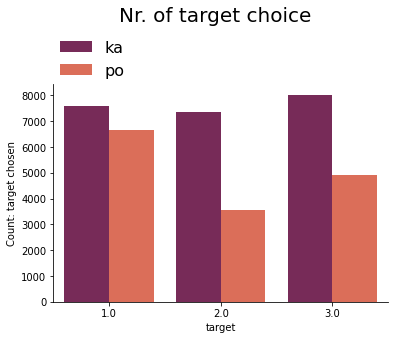

In [20]:
sns.barplot(data = target_prefs, x="target", y = 'count', hue = 'monkey', palette = 'rocket')
sns.despine()
plt.legend(frameon = False, fontsize = 16, loc = (0, 1))
plt.ylabel('Count: target chosen');
plt.suptitle('Nr. of target choice', y = 1.15, fontsize = 20)

plt.savefig(fig_save_path + 'nr_target_choice.png', dpi = 300, bbox_inches='tight');

In [21]:
target_prefs2 = data_subset[['monkey', 'best_target', 'best_chosen_match']].groupby(['monkey', 'best_target']).mean()
target_prefs2.reset_index(inplace=True)
#target_prefs2

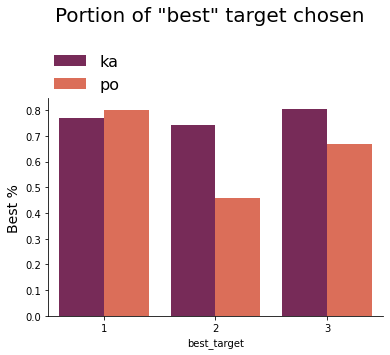

In [22]:
sns.barplot(data = target_prefs2, x="best_target", y = 'best_chosen_match', hue = 'monkey', palette = 'rocket')
sns.despine()
plt.ylabel('Best %', fontsize = 14)
plt.legend(frameon = False, fontsize = 16, loc = (0,1));
plt.suptitle('Portion of "best" target chosen', fontsize = 20, y = 1.2)
plt.savefig(fig_save_path + 'percent_target_choice.png', dpi = 300, bbox_inches='tight');

## T-tests

In [23]:
## NB!! Here I droped the session where there is no "best target == 2" in order to avoid nan values. 
## It would worth to check whether the omitted (e.g. no target choice) values are also not equally distributed, 
## thus involves some distortion. 

In [24]:
best_chosen_per_block = data_subset[['monkey', 'session', 'best_target', 'best_chosen_match']].groupby(['monkey', 'session', 'best_target']).mean()
best_chosen_per_block = best_chosen_per_block.unstack(2)
best_chosen_per_block = best_chosen_per_block.droplevel(0, axis = 1)

In [25]:
data_subset.loc[(data_subset['monkey'] == 'po') &
                (data_subset['session'] == 220422)].best_target.value_counts()

Series([], Name: count, dtype: int64)

In [26]:
def calculate_t_test(monkey, target1, target2):
    results = sp.stats.ttest_ind(best_chosen_per_block.loc[monkey, target1].dropna(), best_chosen_per_block.loc[monkey, target2].dropna())
    print ('T-test for {}, compare target{} & target{}: t-value {:.3f}, p-value {:.3f}'.format(monkey, target1, target2, results.statistic, results.pvalue))

In [27]:
calculate_t_test('ka', 1, 2)
calculate_t_test('ka', 1, 3)
calculate_t_test('ka', 2, 3)

T-test for ka, compare target1 & target2: t-value 1.175, p-value 0.242
T-test for ka, compare target1 & target3: t-value -1.497, p-value 0.137
T-test for ka, compare target2 & target3: t-value -3.789, p-value 0.000


In [28]:
calculate_t_test('po', 1, 2)
calculate_t_test('po', 1, 3)
calculate_t_test('po', 2, 3)

T-test for po, compare target1 & target2: t-value 6.652, p-value 0.000
T-test for po, compare target1 & target3: t-value 3.325, p-value 0.001
T-test for po, compare target2 & target3: t-value -2.926, p-value 0.004


## Proportion of best target among the chosen ones / block

In [29]:
best_chosen_per_block = data_subset[['monkey', 'session', 'block_id', 'best_chosen_match']].groupby(['monkey', 'session', 'block_id']).mean()

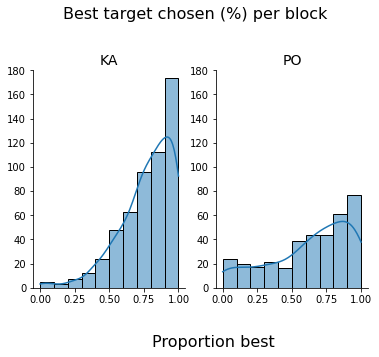

In [30]:
fig, ax = plt.subplots(1, 2, facecolor = 'white')
sns.histplot(best_chosen_per_block.loc['ka', :].best_chosen_match, kde = True, ax = ax[0], bins = 10);
sns.histplot(best_chosen_per_block.loc['po', :].best_chosen_match, kde = True, ax = ax[1], bins = 10);

ax[0].set_title('KA', fontsize = 14)
ax[1].set_title('PO', fontsize = 14)


fig.text(0.4, -0.08, 'Proportion best', fontsize = 16)
sns.despine()

for ax in fig.axes:
    ax.set_ylim(0, 180)
    ax.set_ylabel(None)
    ax.set_xlabel(None)


plt.suptitle('Best target chosen (%) per block', fontsize = 16, y = 1.1);
plt.savefig(fig_save_path + 'hist_best_target.png', dpi = 300, bbox_inches='tight');

## Proportion of best target among the chosen ones / block - cummulative

In [31]:
best_chosen_match_data = data_subset[['monkey', 'session', 'block_id', 'best_target', 'best_chosen_match']].groupby(['monkey', 'session', 'block_id', 'best_target']).mean()
best_chosen_match_data.reset_index(inplace=True)

In [32]:
dat = {'monkey':[], 'percent match':[], 1: [], 2:[], 3:[]}

for monkey in ['ka', 'po']:
    for i in np.linspace(0, 1, 100):
        
        count = best_chosen_match_data.loc[  (best_chosen_match_data['monkey'] == monkey)
                               & (best_chosen_match_data['best_chosen_match'] < i)
                              ].best_target.value_counts()

        dat['percent match'].append(np.round(i, 4))
        dat['monkey'].append(monkey)


        try:
            dat[1].append(count[1])
        except KeyError:
            dat[1].append(0)

        try:
            dat[2].append(count[2])
        except KeyError:
            dat[2].append(0)


        try:
            dat[3].append(count[3])
        except KeyError:
            dat[3].append(0)

dat = pd.DataFrame(dat)

## Portion of best target chosen - cummulative

In [33]:
dat_ka = dat.loc[dat['monkey'] == 'ka']
dat_po = dat.loc[dat['monkey'] == 'po']

In [34]:
p05 = dat_po.loc[(dat_po["percent match"] < 0.5) & (dat_po["percent match"] > .49)]
v = np.array(p05[[1, 2, 3]])
v[0]

array([ 5, 60, 33])

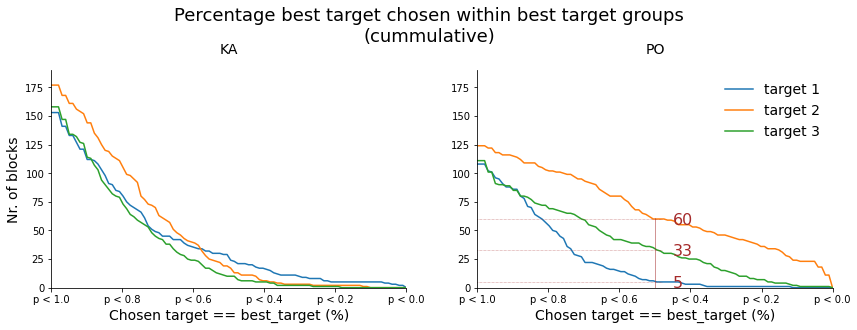

In [35]:
fig, ax = plt.subplots(1, 2, facecolor = 'white', figsize = (14, 4))

### KA ###
sns_plot = sns.lineplot(ax = ax[0], data = dat_ka, x = 'percent match', y = 1, label = 'target 1', lw = 1.5)
sns_plot = sns.lineplot(ax = ax[0], data = dat_ka, x = 'percent match', y = 2, label = 'target 2', lw = 1.5)
sns_plot = sns.lineplot(ax = ax[0], data = dat_ka, x = 'percent match', y = 3, label = 'target 3', lw = 1.5)
ax[0].set_xlim(1, 0)
ax[0].set_xticks(np.arange(0, 1.2, 0.2))
ax[0].set_xticklabels(['p < '+str(item) for item in np.round(np.arange(0, 1.2, 0.2), 1)])
ax[0].set_xlabel('Chosen target == best_target (%)', fontsize = 14)
ax[0].set_ylim(0, 190)
ax[0].set_ylabel('Nr. of blocks', fontsize = 14)
ax[0].set_title('KA', y = 1.05, fontsize = 14)
ax[0].legend([], frameon = False)


### PO ###
sns.lineplot(ax = ax[1], data = dat_po, x = 'percent match', y = 1, label = 'target 1', lw = 1.5)
sns.lineplot(ax = ax[1], data = dat_po, x = 'percent match', y = 2, label = 'target 2', lw = 1.5)
sns.lineplot(ax = ax[1], data = dat_po, x = 'percent match', y = 3, label = 'target 3', lw = 1.5)
ax[1].set_xlim(1, 0)
ax[1].set_ylim(0, 190)
ax[1].set_ylabel(None)
ax[1].set_title('PO', y = 1.05, fontsize = 14)
ax[1].set_xlabel('Chosen target == best_target (%)', fontsize = 14)

ax[1].set_xticks(np.arange(0, 1.2, 0.2))
ax[1].set_xticklabels(['p < '+str(item) for item in np.round(np.arange(0, 1.2, 0.2), 1)])
ax[1].axvline(x = 0.5, ymax = 0.32, color = 'brown', lw = 0.5)

p05 = dat_po.loc[(dat_po["percent match"] < 0.5) & (dat_po["percent match"] > .49)]
values = np.array(p05[[1, 2, 3]])

texx, texy = 0.45, 14
for v in values[0]:
    ax[1].axhline(y = v, xmax = 0.52, color = 'brown', lw = 0.5, linestyle = ':')
    ax[1].text(texx, v-5, v, fontsize = 16, color = "brown")


sns.despine()

plt.legend(frameon = False, fontsize = 14)


plt.suptitle('Percentage best target chosen within best target groups\n(cummulative)', y = 1.1, fontsize = 18);
plt.savefig(fig_save_path + 'cummulative_best_percent2.png', dpi = 300, bbox_inches='tight');

## Session-wide view

In [239]:
best_chosen_match_data = data_subset[['monkey', 'date', 'best_target', 'best_chosen_match']].groupby(['monkey', 'date', 'best_target']).mean()
best_chosen_match_data.reset_index(inplace=True)

In [240]:
best_chosen_match_data_ka = best_chosen_match_data.loc[best_chosen_match_data['monkey'] == 'ka']
best_chosen_match_data_ka = best_chosen_match_data_ka[['date', 'best_target', 'best_chosen_match']].set_index(['date', 'best_target']).unstack()
best_chosen_match_data_ka = best_chosen_match_data_ka.droplevel(0, axis = 1)

In [241]:
best_chosen_match_data_po = best_chosen_match_data.loc[best_chosen_match_data['monkey'] == 'po']
best_chosen_match_data_po = best_chosen_match_data_po[['date', 'best_target', 'best_chosen_match']].set_index(['date', 'best_target']).unstack()
best_chosen_match_data_po = best_chosen_match_data_po.droplevel(0, axis = 1)

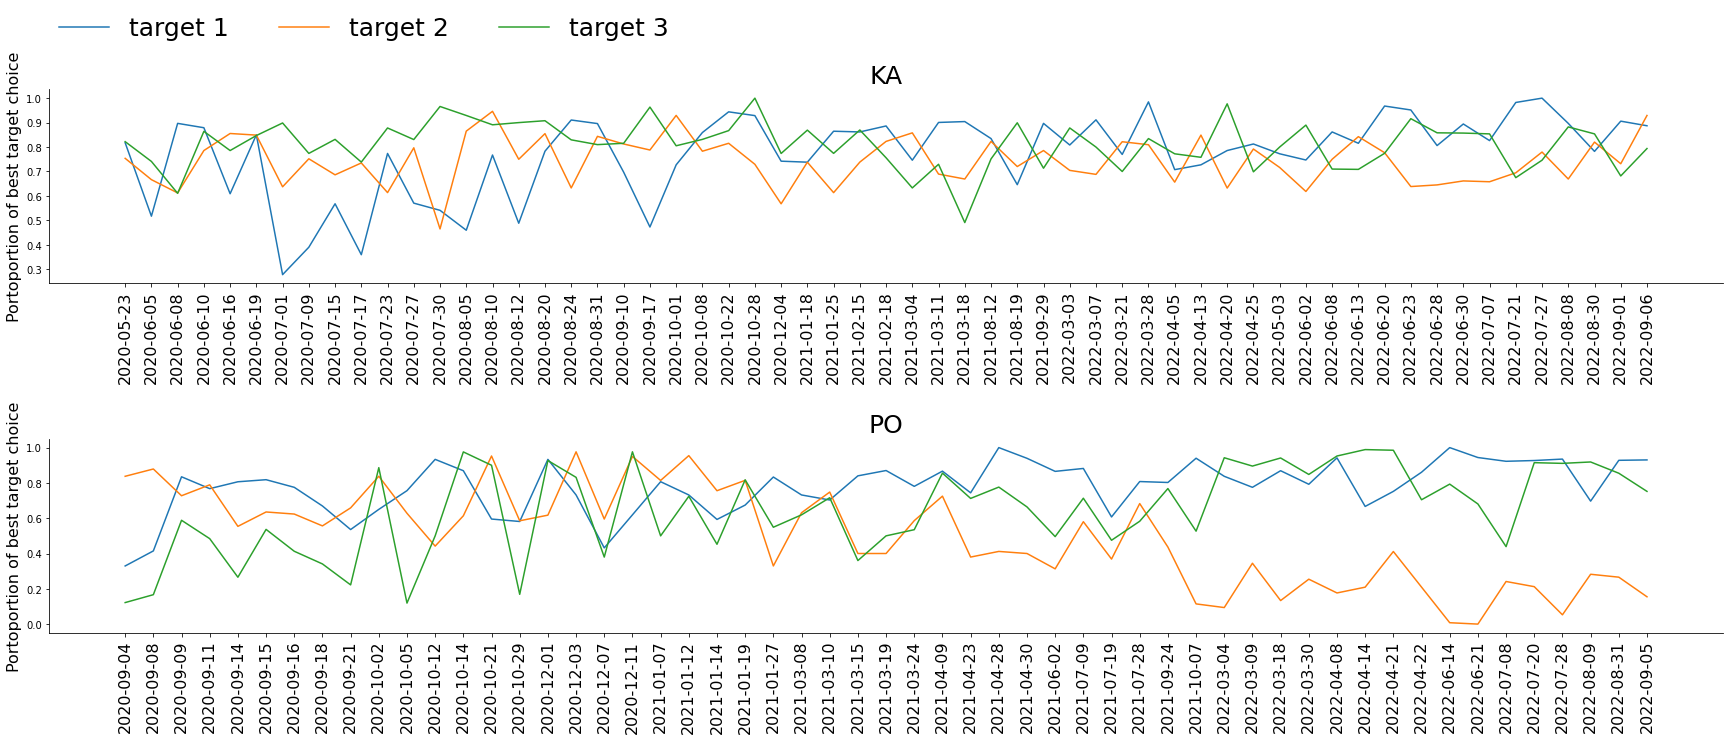

In [242]:

fig, ax = plt.subplots(2,1, figsize = (30, 10), facecolor = 'white')


for i, dat in zip([0, 1], [best_chosen_match_data_ka, best_chosen_match_data_po]):
    idx = [str(item) for item in dat.index]
    
    sns.lineplot(ax = ax[i], data = dat, x = idx, y = 1, lw = 1.5, label = 'target 1')
    sns.lineplot(ax = ax[i], data = dat, x = idx, y = 2, lw = 1.5, label = 'target 2')
    sns.lineplot(ax = ax[i], data = dat, x = idx, y = 3, lw = 1.5, label = 'target 3')
    
    ax[i].set_ylabel('Portoportion of best target choice', fontsize = 16)
    ax[i].set_xticks(np.arange(len(idx)), idx, rotation='vertical', fontsize = 16)
    ax[i].legend([], frameon = False)
    
    
ax[0].set_title('KA', fontsize = 25)
ax[1].set_title('PO', fontsize = 25)

sns.despine()


plt.legend(frameon = False, loc = (0, 3), ncols = 3, fontsize = 25)
plt.subplots_adjust(hspace = 0.8)
plt.savefig(fig_save_path + 'best_target_choice_each_session.png', dpi = 300, bbox_inches='tight');

## Smooth the data by averaging

In [243]:
def get_smoothed_data(df, avg_nr_sess = 3):
    i = 0
    smooth = {'sm1':[], 'sm2':[], 'sm3':[]}
    idx = df.index
    for i in range(len(idx)):
        sm1 = df.loc[idx[i: i+avg_nr_sess], 1].mean()
        sm2 = df.loc[idx[i: i+avg_nr_sess], 2].mean()
        sm3 = df.loc[idx[i: i+avg_nr_sess], 3].mean()

        smooth['sm1'].append(sm1)
        smooth['sm2'].append(sm2)
        smooth['sm3'].append(sm3)
        i += 1

    return pd.DataFrame(smooth)

In [244]:
ka_smooth_3 = get_smoothed_data(best_chosen_match_data_ka, avg_nr_sess = 3)
po_smooth_3 = get_smoothed_data(best_chosen_match_data_po, avg_nr_sess = 3)

ka_smooth_4 = get_smoothed_data(best_chosen_match_data_ka, avg_nr_sess = 4)
po_smooth_4 = get_smoothed_data(best_chosen_match_data_po, avg_nr_sess = 4)

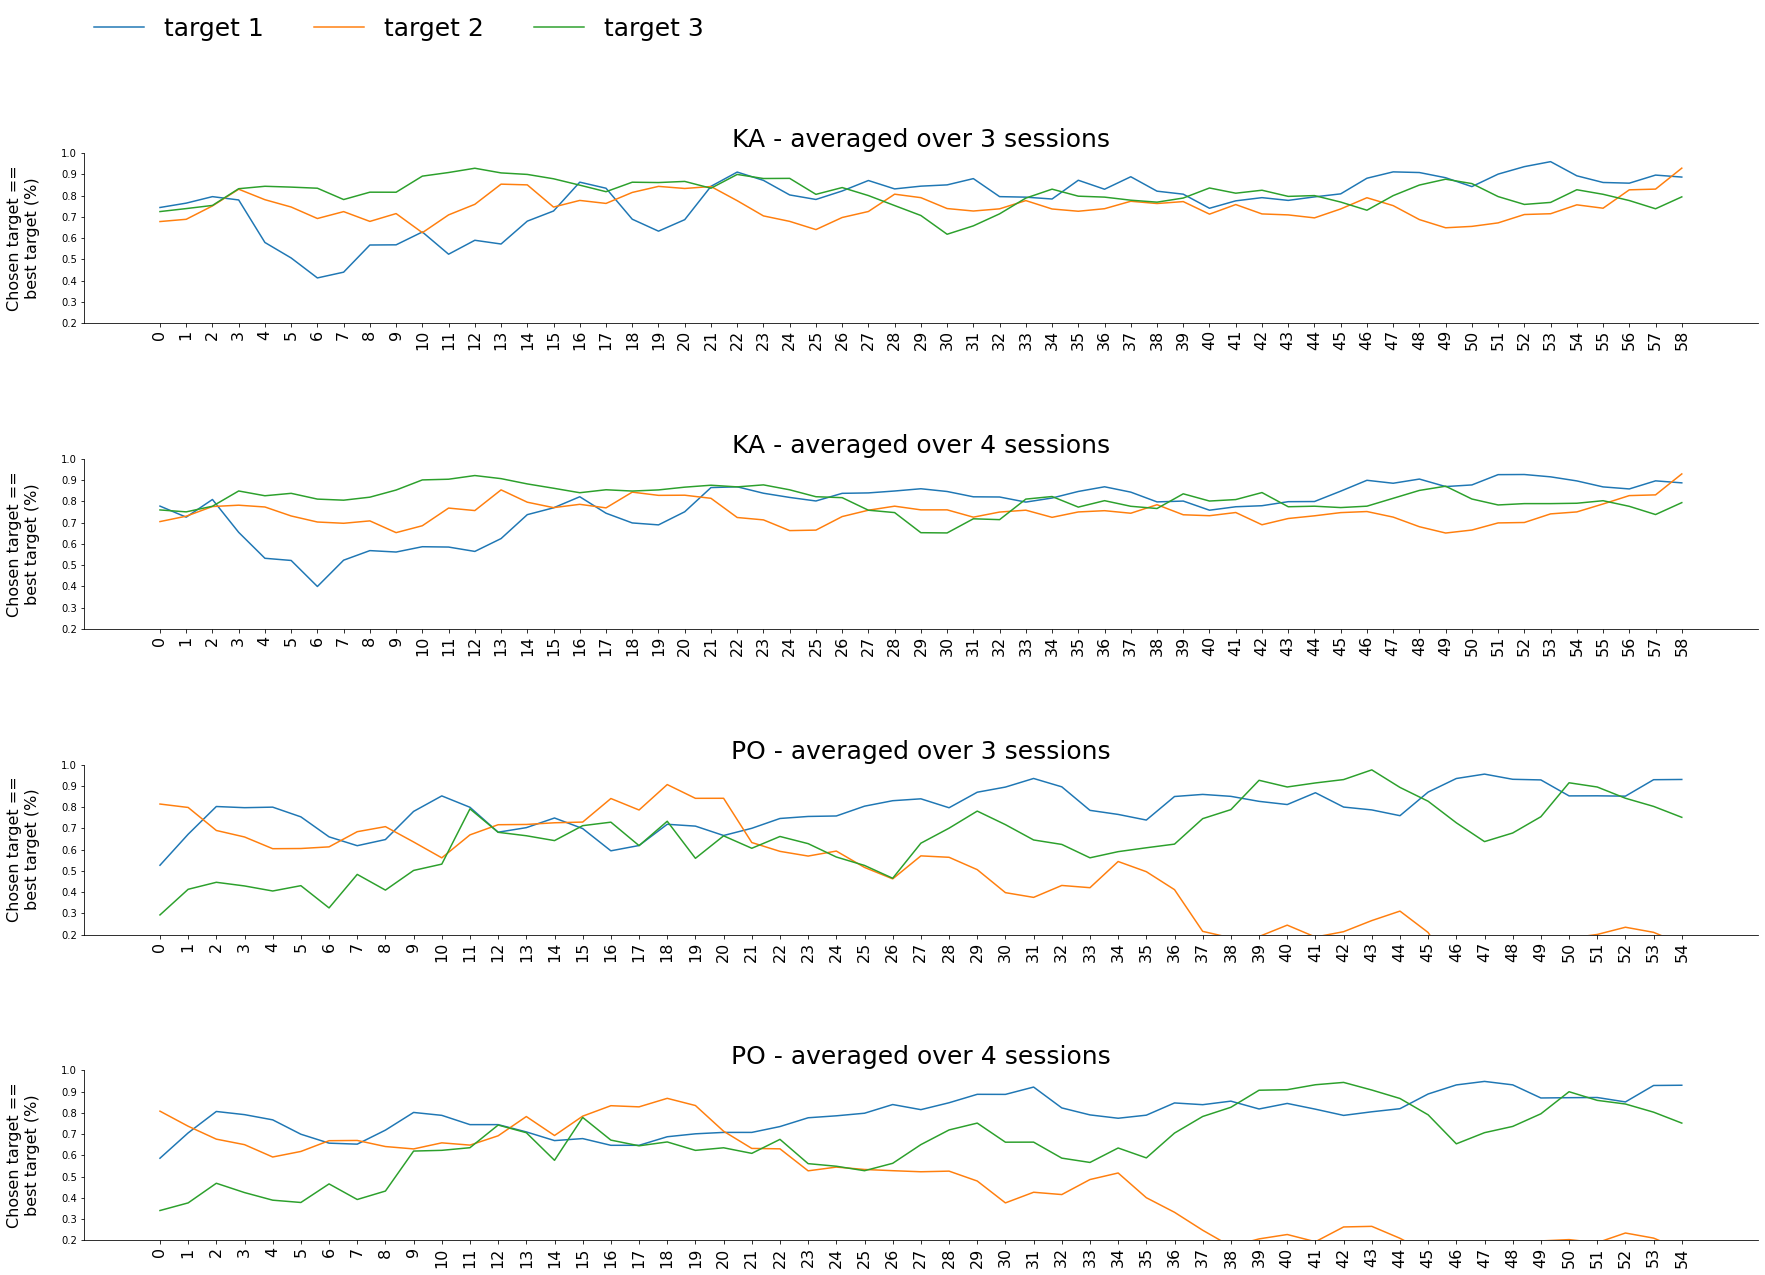

In [245]:
fig, ax = plt.subplots(4,1, figsize = (30, 20), facecolor = 'white')


for i, dat in zip([0, 1, 2, 3], [ka_smooth_3, ka_smooth_4, po_smooth_3, po_smooth_4]):
    idx = [str(item) for item in dat.index]
    
    sns.lineplot(ax = ax[i], data = dat, x = idx, y = 'sm1', lw = 1.5, label = 'target 1')
    sns.lineplot(ax = ax[i], data = dat, x = idx, y = 'sm2', lw = 1.5, label = 'target 2')
    sns.lineplot(ax = ax[i], data = dat, x = idx, y = 'sm3', lw = 1.5, label = 'target 3')
    
    ax[i].set_ylabel('Chosen target ==\nbest target (%)\n', fontsize = 16)
    ax[i].set_xticks(np.arange(len(idx)), idx, rotation='vertical', fontsize = 16)
    ax[i].legend([], frameon = False)
    ax[i].set_ylim(0.2, 1)
    
    
ax[0].set_title('KA - averaged over 3 sessions', fontsize = 25)
ax[1].set_title('KA - averaged over 4 sessions', fontsize = 25)
ax[2].set_title('PO - averaged over 3 sessions', fontsize = 25)
ax[3].set_title('PO - averaged over 4 sessions', fontsize = 25)



sns.despine()


plt.legend(frameon = False, loc = (0, 7), ncols = 3, fontsize = 25)
plt.subplots_adjust(hspace = 0.8)

plt.savefig(fig_save_path + 'best_target_smoothed.png', dpi = 300, bbox_inches='tight');